In [1]:
#!jupyter nbconvert --to script TrainSpeedProfile.ipynb

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import os
from openpyxl import load_workbook
from openpyxl.drawing.image import Image


In [3]:
# Get the current working directory and create the 'image' subfolder
current_dir = os.getcwd()
excel_dir = os.path.join(current_dir, "sheet")
if not os.path.exists(excel_dir):
    os.makedirs(excel_dir)
excel_path = os.path.join(excel_dir, "output.xlsx")
plot_path = os.path.join(excel_dir, "plot.png")


In [4]:
# Load the CSV files
# The CSV files contain the input parameters
stations = pd.read_csv('stations.csv') # Station and their chainage
curves = pd.read_csv('curves.csv') # Curves data including start, end, radius
gradients = pd.read_csv('gradients.csv') # Gradient data including start, end
speed_restrictions = pd.read_csv('sr.csv') # Speed restriction associated with curve

# Load the train parameters CSV file
train_params = pd.read_csv('train_parameters.csv')# Train parameters

print(type(train_params))
#print(curves.columns)


<class 'pandas.core.frame.DataFrame'>


In [5]:
# Convert the 'Value' column to a dictionary for easy access
train_params_dict = pd.Series(train_params.Value.values, index=train_params.Parameter).to_dict()

# Create a dictionary to map radius to speed restriction
speed_limit_dict = pd.Series(speed_restrictions.Speed_Limit.values, index=speed_restrictions.Radius).to_dict()

# Extract values from the dictionary
acceleration = float(train_params_dict['Acceleration_rate_1'])
acceleration_switch = float(train_params_dict['Acceleration_rate_2'])
switch_speed = float(train_params_dict['Switch_speed'])
braking_deceleration = float(train_params_dict['Braking_rate'])
max_speed = float(train_params_dict['Maximum_speed'])  # Assuming the speed is in km/h, convert to m/s
coasting_limit = float(train_params_dict['Coasting_limit'])
stop_duration = int(train_params_dict['Stop_duration'])
regen_efficiency = float(train_params_dict['Regeneration_efficiency'])  # Efficiency of regeneration

# Frictional and Inertial constant
starting_resistance = float(train_params_dict['Starting_resistance'])  # All inclusive of static friction and other resistive forces.
static_friction = float(train_params_dict['Static_friction']) # Interaction at wheel - rail initial contact
rolling_resistance = float(train_params_dict['Rolling_resistance'])
air_resistance = float(train_params_dict['Air_resistance'])
mass = float(train_params_dict['Train_mass'])  # Train weight in tons
mc_mass = float(train_params_dict['MC_mass'])  # Motor car weight
tc_mass = float(train_params_dict['TC_mass'])  # Trailer Car weight
inertia_mass_m = float(train_params_dict['Inertia_mass_m'])  # Intertial coefficient of motor car
inertia_mass_t = float(train_params_dict['Inertia_mass_t'])  # Intertial coefficient of trailer car

motor_nos = float(train_params_dict['Motor_nos'])  # Number of driving motors in train


In [6]:
# Extract the chainage and station names
station_chainages = stations['Chainage'].values
station_names = stations['Station_Name'].values
#print(len(station_names))

#print(f'static_friction:{static_friction},mass:{mass}')
#print(f'Acceleration 2:{acceleration_switch}')

In [7]:
# Convert speeds from km/h to m/s
max_speed = max_speed * 1000 / 3600
switch_speed = switch_speed * 1000 / 3600

no_coasting = False # Flag for coasting, true if present

accelerating_distance = max_speed**2/2/acceleration_switch
braking_distance = max_speed**2/2/braking_deceleration


In [8]:
# Davis formula for resistance
def davis(speed):
    return (static_friction + rolling_resistance * speed + air_resistance * speed**2) * mass


In [9]:
# Helper function to log time and speed
def log_simulation_data(time, speed, time_log, speed_log):
    time_log.append(time / 60)  # Convert time to minutes for logging
    speed_log.append(speed * 18 / 5)  # Convert m/s to km/h for logging

In [10]:
def accelerate(speed, acceleration, max_speed, time_step=1):
    """
    Calculate the increased speed during coasting due to accelerating effort.

    Parameters:
    - speed (float): Current speed of the train (m/s).
    - acceleration (float): The acceleration rate.
    - time_step (float): Time over which to calculate the speed reduction (seconds). Default is 1 second.

    Returns:
    - float: The new reduced speed after applying friction forces.
    """
    #print(f'Speed:{speed}, Accel:{acceleration}')
    speed += acceleration * time_step
    if speed > max_speed:
        speed = max_speed
        
    return speed


In [11]:
def brake(speed, braking, time_step=1):
    """
    Calculate the reduced speed during coasting due to braking effort.

    Parameters:
    - speed (float): Current speed of the train (m/s).
    - braking (float): The braking rate.
    - time_step (float): Time over which to calculate the speed reduction (seconds). Default is 1 second.

    Returns:
    - float: The new reduced speed after applying friction forces.
    """
    speed -= braking * time_step
    if speed < 0:
        speed = 0

    return speed


In [12]:
def coast(speed, time_step=1):
    """
    Calculate the reduced speed during coasting due to friction forces.

    Parameters:
    - speed (float): Current speed of the train (m/s).
    - mass (float): Mass of the train (in tons).
    - static_friction (float): Static friction coefficient (N/ton).
    - rolling_resistance (float): Rolling resistance coefficient (N/ton/m/s).
    - air_resistance (float): Air resistance coefficient (N/ton/m^2/s^2).
    - time_step (float): Time over which to calculate the speed reduction (seconds). Default is 1 second.

    Returns:
    - float: The new reduced speed after applying friction forces.
    """

    if (no_coasting):
        return speed
        
    # Convert mass from tons to kg (1 ton = 1000 kg)
    mass_kg = mass * 1000

    # Calculate the total resistance (Davis equation)
    resistance = davis(speed)

    # Calculate deceleration due to resistance (force/mass)
    deceleration = resistance / mass_kg  # in m/s²

    # Calculate the new speed after deceleration due to resistance
    speed -= deceleration * time_step
    if speed < 0:
        speed = 0

    return speed

In [13]:
# Function to find the speed restriction at a given distance
def get_speed_restriction(distance):
    """
    Applies the Speed Restriction if the train is in SR zone.

    Parameters:
    - distance (float): The current position of the train wrt origin

    Returns:
    - float: If the Train is in SR zone, the speed is reduced to a specified restricted speed.
    """
    for i in range(len(curves)):
        start = curves.iloc[i]['Start']
        end = curves.iloc[i]['End']
        radius = curves.iloc[i]['Radius']
        
        # Check if the current distance falls within the curve zone
        if start <= distance <= end:
            # Return the speed restriction for the corresponding radius
            return speed_limit_dict.get(radius, None)  * 1000 / 3600 # Returns None if radius not found
    return None  # No speed restriction if distance is outside curve zones


In [14]:
def accelerate_phase(time, initial_speed, distance, max_speed, acceleration, time_log, speed_log, power_log, mass):
    speed = initial_speed
    segment_time = 0
    while distance < accelerating_distance:
        acceleration_loop = acceleration if speed < switch_speed else acceleration_switch
        speed = accelerate(speed, acceleration_loop, max_speed, time_step=1)
        distance += speed
        
        power = power_consumed(mass, acceleration_loop, speed)
        power_log.append(power)
        
        log_simulation_data(time, speed, time_log, speed_log)
        
        if speed >= max_speed:
            break
        else:
            time += 1
        
        segment_time += 1

    return time, speed, distance, segment_time

In [15]:
# Function to handle coasting phase
def coasting_phase(time, speed, distance, 
                   segment_distance, braking_distance, segment_time,
                   max_speed, coasting_limit, 
                   time_log, speed_log):

    # Flag to indicate when we should continue accelerating to reach max speed
    should_accelerate = False

    while distance < (segment_distance - braking_distance):
        if speed > coasting_limit * max_speed and not should_accelerate:
            speed = coast(speed, time_step=1)
        else:
            should_accelerate = True
            speed = accelerate(speed, acceleration, max_speed, time_step=1)

        if speed >= max_speed:
            speed = max_speed
            should_accelerate = False
        
        speed_limit = get_speed_restriction(covered_distance + distance)
        if speed_limit:
            speed = speed_limit

        distance += speed
        segment_time += 1
        time += 1
        log_simulation_data(time, speed, time_log, speed_log)

    return time, speed, distance, segment_time

In [16]:
# Function to handle braking phase
def braking_phase(time, speed, distance, 
                  segment_distance, braking_deceleration, segment_time,
                  time_log, speed_log, power_log, 
                  mass, regen_efficiency):

    while distance < segment_distance:
        speed = brake(speed, braking_deceleration, time_step=1)
        distance += speed
        if speed <= 0:
            break
        else:
            time += 1
        
        power = power_consumed(mass, braking_deceleration, speed)
        power_log.append(-power * regen_efficiency)  # Regenerated power

        segment_time += 1
        log_simulation_data(time, speed, time_log, speed_log)

    return time, speed, distance, segment_time


In [17]:
def power_consumed(mass, acceleration,speed):
    force = mass * 1000 * acceleration  # Force in Newtons
    power = force * speed  # Power in Watts

    return power

In [18]:
# Function to handle station stop phase
def station_stop_phase(time, stop_duration, time_log, speed_log):
    for _ in range(stop_duration):
        time += 1
        log_simulation_data(time, 0, time_log, speed_log)
    return time


In [19]:
# Run the Simulation

# Initialize simulation variables
time = 0
speed = 0
distance = 0
covered_distance = 0
time_log = []
speed_log = []
power_log = []
section_avg_speed = []

# Simulate the movement from station to station
for i in range(len(station_names)-1):
    start_station = station_chainages[i]
    end_station = station_chainages[i+1]
    segment_distance = end_station - start_station
    #print(f'Next Station: {segment_distance} Distance Covered: {covered_distance} Reset:{distance}')
    segment_time = 0
    distance = 0
    speed = 0
    
    # Accelerate after leaving the station
   # Acceleration phase
    time, speed, distance, segment_time = accelerate_phase(
        time, speed, 0, max_speed, acceleration, time_log, speed_log, power_log, mass
    )

    # Coast until speed drops to 80% of the max speed

    # Coasting phase
    time, speed, distance, coasting_time = coasting_phase(time, speed, distance, 
                   segment_distance, braking_distance, segment_time,
                   max_speed, coasting_limit, 
                   time_log, speed_log)
    
    # Brake before reaching the station
    time, speed, distance, segment_time = braking_phase(time, speed, distance, 
                  segment_distance, braking_deceleration, segment_time,
                  time_log, speed_log, power_log, 
                  mass, regen_efficiency)

    # Stop at the station for 30 seconds
    #stop_duration = 30 
    # Stop at station
    time = station_stop_phase(time, stop_duration, time_log, speed_log)

    covered_distance += segment_distance
    segment_avg_speed = segment_distance / segment_time  * 18 / 5
    section_avg_speed.append(segment_avg_speed)
    #print(segment_avg_speed)

# Numerical integration of power to get energy in Joules
energy_consumed = np.trapezoid(power_log, dx=1)  # dx=1 because time step is 1 second

# Convert energy from Joules to kWh
energy_consumed_kwh = energy_consumed / 3600_000

print(f"Total energy consumed during the run: {energy_consumed_kwh:.3f} kWh")

#print(f'time:{time_log}')
#print(f'speed:{speed_log}')
#print(f'power:{power_log}')
#print(f'Section Average Speed:{section_avg_speed}')


Total energy consumed during the run: 224.262 kWh


In [20]:
te_start = mass * starting_resistance / 1000 # Starting Effort in kN
te_rolling = (mass + 
              mc_mass * inertia_mass_m * 2 + 
             tc_mass * inertia_mass_t) * acceleration # Moving Effort
te_total = te_start + te_rolling # Total Effort
te_motor = te_total / motor_nos # Effort per Motor
motor_rating = te_motor * switch_speed  # Motor Rating

print(f'Required Tractive effort:{te_motor},\t Motor Rating:{motor_rating}')
#print(acceleration)

Required Tractive effort:27.530625,	 Motor Rating:305.8958333333333


In [21]:
# Average Speed
# Calculate the average speed
total_distance = station_chainages[-1] - station_chainages[0]
average_speed = total_distance / time
print(f"A total distance of {total_distance/1000:.2f} Km was covered in {time/60:.2f} minutes.")
print(f"Average speed for the trip was: {average_speed*18/5:.2f} km/hr")


A total distance of 35.78 Km was covered in 47.83 minutes.
Average speed for the trip was: 44.88 km/hr


In [22]:
def chainage(station_chainages, section_avg_speed):
    # Calculate distances between consecutive stations
    distances_between_stations = [station_chainages[i+1] - station_chainages[i] for i in range(len(station_chainages)-1)]

    from_station = []
    to_station = []
    interstation_distance = []
    seperator = []
    for i in range(len(distances_between_stations)):
        from_station.append(station_names[i])
        to_station.append(station_names[i+1])
        interstation_distance.append(distances_between_stations[i])
        seperator.append('--')

    data = {
        "Station From":from_station,
        " ":seperator,
        "Station To":to_station,
        "Distance":interstation_distance,
        "Section Speed":section_avg_speed
    }

    # Create DataFrame
    df = pd.DataFrame(data)

    return df


In [23]:
def generate_spreadsheet(
    excel_path: str, 
    plot_path: str, 
    time_log: list[float], 
    speed_log: list[float], 
    station_chainages: list[float], 
    section_avg_speed: list[float], 
    average_speed: float, 
    energy_consumed_kwh: float, 
    total_time: float
) -> None:
    """
    Generates a spreadsheet report of the train simulation, including a plot.

    Parameters:
    - excel_path (str): Path to save the Excel report.
    - plot_path (str): Path to save the generated plot image.
    - time_log (list of float): List of timestamps for the simulation.
    - speed_log (list of float): List of speed values corresponding to time_log.
    - station_chainages (list of float): Chainages of the stations.
    - section_avg_speed (list of float): Average speed for each section between stations.
    - average_speed (float): Overall average speed of the train.
    - energy_consumed_kwh (float): Total energy consumed during the simulation in kWh.
    - total_time (float): Total time taken for the simulation in seconds.
    """

    data = {
    "Speed":speed_log,
    "Time":time_log
    }
    # Create DataFrame
    df_speed = pd.DataFrame(data)
    
    df_speed.to_excel(excel_path, index=False, sheet_name="Data")  # Save data to Excel

    # Define the new DataFrame
    df_average = chainage(station_chainages, section_avg_speed)

    # Append the new DataFrame to a new sheet in the same Excel file
    with pd.ExcelWriter(excel_path, mode='a', engine='openpyxl') as writer:
        df_average.to_excel(writer, index=False, sheet_name="Speed")

    # Insert the plot image into the Excel file
    wb = load_workbook(excel_path)
    ws_plot = wb.create_sheet("Plot")
    img = Image(plot_path)
    ws_plot.add_image(img, "A1")  # Insert image starting at cell A1

    # Insert custom text at the top of the "Speed" sheet
    ws_speed = wb["Speed"]
    for _ in range(6):
        ws_speed.insert_rows(1)  # Insert a blank row at the top
    #ws_speed.insert_rows(1)  # Insert a blank row at the top
    ws_speed["A1"] = f"A total distance of {total_distance/1000:.2f} Km was covered in {time/60:.2f} minutes."# Add custom text in cell A1
    ws_speed["A2"] = f"Average speed for the trip was: {average_speed*18/5:.2f} Km/hr"# Add custom text in cell A1
    ws_speed["A3"] = f"Total energy consumed during the run: {energy_consumed_kwh:.3f} kWh"# Add custom text in cell A1
    wb.save(excel_path)

    return


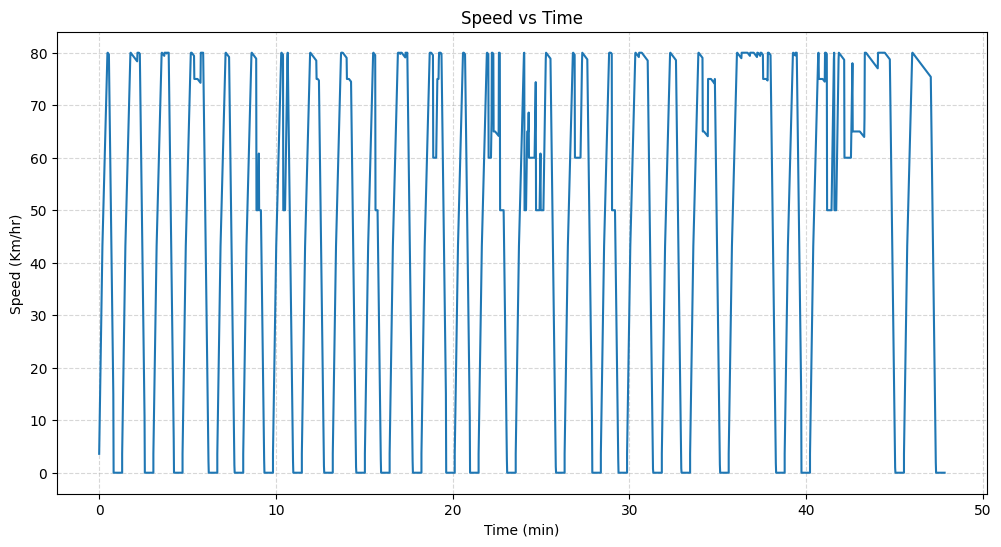

In [24]:
# Plot the speed vs time graph
fig = plt.figure(figsize=(12, 6))

plt.plot(time_log, speed_log)
plt.title('Speed vs Time')
plt.xlabel('Time (min)')
plt.ylabel('Speed (Km/hr)')

# Add grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.5)


plt.savefig(plot_path)

plt.show()




***Stations Distances***

In [25]:
# Save results in excel sheet
generate_spreadsheet(
    excel_path, 
    plot_path, 
    time_log, 
    speed_log, 
    station_chainages, 
    section_avg_speed, 
    average_speed, 
    energy_consumed_kwh, 
    time
)



To account for friction during the cruising (now coasting) phase, we can incorporate the train resistance equation. The coasting phase will involve the train gradually decelerating due to the resistance force. The train resistance (friction) is commonly modeled using a quadratic or linear function of speed, such as:

$\large
F_r = A + Bv + Cv^2
$

Where:
- $ F_r $ is the total resistance (in Newtons).
- $ A $, $ B $, and $ C $ are coefficients for the train resistance (typically dependent on the type of train).
- $ v $ is the train's velocity during coasting.

**Hundai Rotem** for LTMRHL

$ \large R = 14.01 + 0.264 \times V + 0.00191 \times V^2 $

- R: Train Resistance in N/Ton
- V: Train Speed in Km/h


***Explanation***

The average speed of a metro train can be calculated by analyzing the phases of the journey: acceleration, cruising at max speed, and braking.

To derive the average speed, we can use the following logic:

1. **Acceleration Phase**: The train accelerates from 0 to maximum speed.
2. **Cruising Phase**: The train maintains the maximum speed until it begins braking.
3. **Coasting Phase**: The train's speed gradually decreases due to the deceleration caused by friction, which depends on the current speed.
4. **Braking Phase**: The train decelerates to 0 at the destination.

The total distance covered during acceleration and braking can be split up.

$\large t_a = \frac{m}{a}$, 

$\large t_b = \frac{m}{b}$


The equation for motion during the coasting phase will now take into account this resistance. The deceleration due to resistance can be computed using:

$\huge
a_{\text{coast}} = -\frac{F_r}{m_{\text{train}}}
$

Where:
- $ a_{\text{coast}} $ is the deceleration during coasting.
- $ m_{\text{train}} $ is the mass of the train.


$\huge R = \frac{500}{r} $

- R: Curve Resistance in N/Ton
- r: Curve Radius in m

1. **Curve and Gradient Handling**: Instead of assigning a single curve or gradient to a section, we'll calculate their effects cumulatively if there are overlapping curves or gradients.

2. **Resistance Calculations**: The calculate_cumulative_resistance() function computes the total resistances from all applicable curves and gradients at each segment.

***Operation Philosophy***

The train will be one of three modes

- **Acceleration mode**: The train accelerates to it's maximum speed
- **Coasting**: Tractive effort is withdrawn and the train travels on it's own inertia. It slows due to friction
- **Braking**: The train brakes on it's braking power

Time taken to accelerate and deacclerate if distance is not enough to reach maximum speed is:

```python
t_total = np.sqrt(2 * d / (a + b))
```


### Breakdown:

- `d`: The total distance to be traveled.
- `a`: The acceleration rate (in meters per second squared, m/s²).
- `b`: The braking rate (in meters per second squared, m/s²).

### Explanation:

1. **Kinematic equation for displacement (ignoring maximum speed)**:
   The total distance traveled under constant acceleration and braking is given by:

   
   $\huge
   d = \frac{1}{2} a t_{\text{accel}}^2 + \frac{1}{2} b t_{\text{brake}}^2
   $

   Since the train accelerates and brakes symmetrically (one phase follows the other), the total time can be treated as a function of both `a` and `b`. For simplicity, we assume that the assumed acceleration is total of both acceleration and braking:

   
   $\huge
   d = \frac{1}{2} (a + b) t_{\text{total}}^2
   $

3. **Rearranging the equation** to solve for `t_total`:

4. 
   $\huge
   t_{\text{total}} = \sqrt{\frac{2d}{a + b}}
  $

This equation assumes that the entire journey is a combination of acceleration and braking, with no constant-speed coasting phase. 

### Key Points:
- The `t_total` calculation is only valid when the train never reaches the maximum speed.
- The formula simplifies the process by treating the acceleration and braking phases together, assuming symmetrical motion. The distance is split between the acceleration and braking phases.

The formula $P_{\text{required}} = R_{\text{total}} \times v $ is used to calculate the **power required** by a train to overcome various resistances while it is in motion. 

- **Power in Physics**:
  
   $
   P = F \times v
  $
  
   Where:
   - $ P $ is power,
   - $ F $ is the force (in this case, the total resistance),
   - $ v $ is the velocity (speed of the train).


### Example:

- If a train is moving at a speed of 20 m/s and the total resistance it encounters is 300 N, the power required to maintain that speed would be calculated as follows:
  
  $
  P_{\text{required}} = R_{\text{total}} \times v = 300 \, \text{N} \times 20 \, \text{m/s} = 6000 \, \text{W} 
  $

This means the train needs to produce at least 6000 watts (6 Kw) of power to maintain that speed against the resistance. If the power available from the train's motor is less than this, it will start to decelerate.

***Motor Rating***

**Tractive Effort** = Tractive Effort at **Start** + Tractive Effort on **Rolling**

Rolling Tractive Effort = (**Tare weight** of Cars $\times$ **Inertial** Co-effecients) $\times$ **Acceleration**

Starting Tractive Effort = **Starting Resistance** $\times$ Train **weight**

Motor **Power Rating** = Tractive Effort $\times$ **Speed**

Introducing curve and gradient resistance into the train's journey adds new complexities to the coasting and cruising phases. Here's how we'll incorporate these factors:

#### Curve Resistance:
- **Curve Resistance** occurs due to the curvature of the track. For a given curve, the additional resistance is calculated as:

$\huge
  R_{\text{curve}} = \frac{600}{\text{radius of the curve in meters}} 
$

#### Gradient Resistance:
- **Gradient Resistance** is the resistance caused by an incline or decline in the track. For a 1 in 100 gradient, the resistance is:

$\huge
  R_{\text{gradient}} = 9.81 \times \frac{1}{100} \times \text{mass of the train (in kg)}
$
